In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - potential_decomposition.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Decompose the MWPotential2014+triaxial halo potential into differential power law
and 
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, copy
# import glob
# import subprocess

## Plotting
from matplotlib import pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import colors
# from matplotlib import cm
# import aplpy

## Astropy
# from astropy.io import fits
# from astropy.coordinates import SkyCoord
# from astropy import table
from astropy import units as apu
# from astropy import wcs

## galpy
# from galpy import orbit
from galpy import potential
from galpy.util import bovy_conversion as gpconv
# from galpy.util import bovy_coords as gpcoords

## Scipy
from scipy.optimize import curve_fit

In [3]:
%matplotlib inline

# First define the MWPotential2014 and the triaxial halo

In [4]:
# Get MWPotential2014, unpack the component potentials, and save copies
mwpot = potential.MWPotential2014
mwbulge = copy.deepcopy(mwpot[0])
mwdisk = copy.deepcopy(mwpot[1])
mwhalo = copy.deepcopy(mwpot[2])

# Get MWPotential2014 potential parameters for physical implementation
mwhalo_a = mwhalo.a * mwhalo._ro * apu.kpc
mwhalo_amp = mwhalo.dens(mwhalo_a,0) * 16 * mwhalo.a**3 * np.pi * \
             gpconv.mass_in_msol(mwhalo._vo, mwhalo._ro) * apu.M_sun

mwdisk_a = mwdisk._a * mwdisk._ro * apu.kpc
mwdisk_b = mwdisk._b * mwdisk._ro * apu.kpc
mwdisk_amp = mwdisk._amp * gpconv.mass_in_msol(mwdisk._vo, mwdisk._ro) * apu.M_sun

mwbulge_r1 = 1
mwbulge_amp = mwbulge.dens(mwbulge_r1,0) * np.exp((1/mwbulge.rc)**2) * \
              gpconv.dens_in_msolpc3(mwhalo._vo, mwhalo._ro) * apu.M_sun / apu.pc**3 
mwbulge_alpha = mwbulge.alpha
mwbulge_rc = mwbulge.rc * mwbulge._ro * apu.kpc

# Make the triaxial halo
trihalo = potential.TriaxialNFWPotential(amp=mwhalo_amp,
                                             a=mwhalo_a,
                                             b=2.0,
                                             c=1.0,
                                             glorder=50)

tripot = [trihalo, mwbulge, mwdisk]

## Define some parameters of this exercise

In [5]:
# Define the radial bins:
r_in = 5
r_out = 15
bin_size = 0.5
n_bins = (r_out-r_in)/bin_size
r_bins = np.arange(r_in, r_out, bin_size)

# Within each bin a number of radial samples will need to be taken
n_r_samp = 50 # Must equal the glorder of TriaxialNFW
r_samp = np.linspace(0, bin_size, num=n_r_samp)

# Within each bin there will a range of azimuth to explore:
n_az_samp = 18
az_samp = np.linspace(0, 2*np.pi, num=n_az_samp)

In [10]:
# Define the power law fitting function:
def power_law(x,A,b,D):
    return A*(x**b)+D
#def

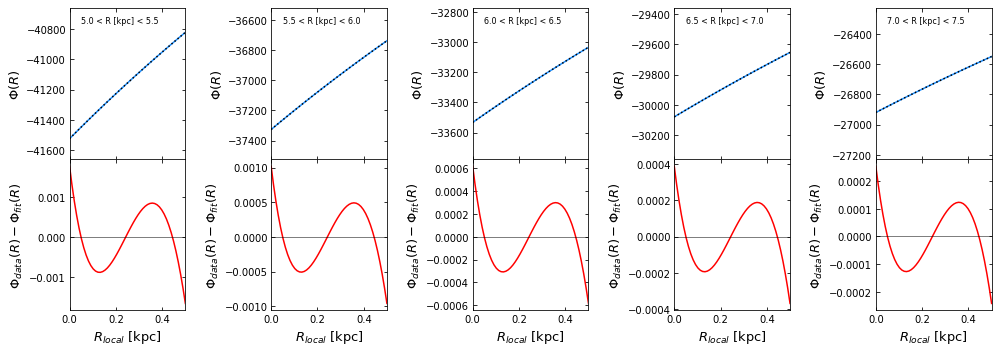

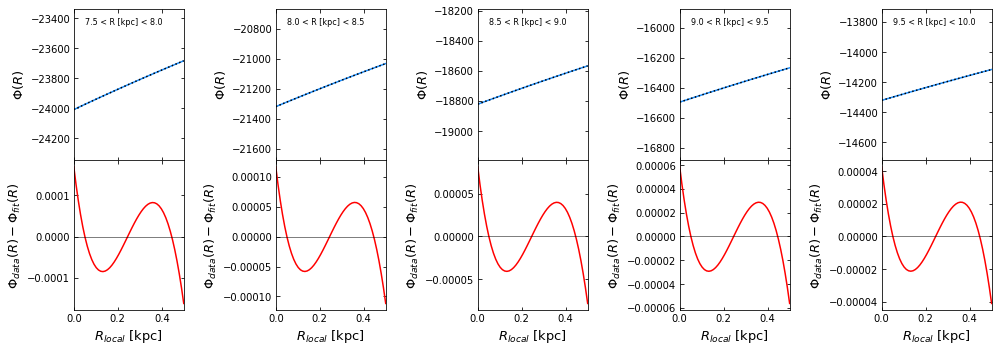

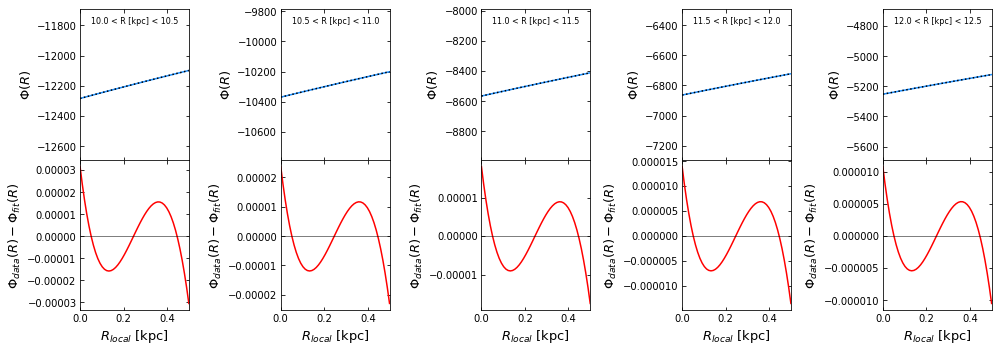

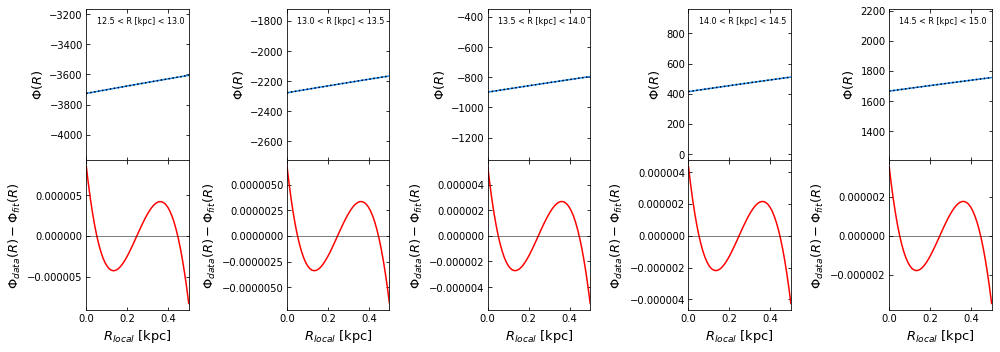

In [47]:
# dummy bin counter
bin_counter = 0

# Do this plotting in groups of 5. Assume that the number of bins will always be a multiple of 5
for i in range( int(n_bins/5) ):
    
    # Make the figure and the subplots
    fig = plt.figure( figsize=(14,5) )
    axs = fig.subplots(nrows=2,ncols=5)
    
    # Now for each radial bin average over azimuth, and do a power law fit.
    for j in range(5):
        
        # Define the array to hold the results from the azimuth sampling of the potentials
        pot_samp = np.zeros((n_az_samp,n_r_samp))
        
        # Loop over a number of azimuthal bins where data will be collected
        for k in range(n_az_samp):
            
            # Evaluate the potential at this azimuth
            # pdb.set_trace()
            pot_samp[k,:] = potential.evaluatePotentials(tripot, r_samp+r_bins[int(5*i+j)], 0., phi=az_samp[k]).value
        ###k
        
        # Now average all the azimuth samples
        avg_pot = np.average(pot_samp, axis=0)
        
        # Now fit the averaged sample
        popt, pcov = curve_fit(power_law, r_samp+r_bins[int(5*i+j)], avg_pot, p0=[200*200,-1,np.average(avg_pot)], ftol=0.1)
        
        # Now plot the averaged sample and the fitted curve
        axs[0,j].plot( r_samp, power_law(r_samp+r_bins[int(5*i+j)], *popt), 
                      color='DodgerBlue', linestyle='solid')
        axs[0,j].plot( r_samp, avg_pot, color='Black', linestyle='dotted')
        
        # Decorate
        axs[0,j].annotate(str(r_bins[int(5*i+j)])+' < R [kpc] < '+str(r_bins[int(5*i+j)]+bin_size),
            (0.1,0.9), xycoords='axes fraction', fontsize=8)
        
        # Adjust
        axs[0,j].set_xlim(0, bin_size)
        axs[0,j].set_ylim( np.average(avg_pot)-500, np.average(avg_pot)+500 )
        axs[0,j].set_ylabel(r'$\Phi(R)$', fontsize=13)
        axs[0,j].tick_params(right='on', top='on', direction='in', labelbottom='off')
        
        # Now plot the difference between the fit and the measurement
        axs[1,j].plot( r_samp, avg_pot-power_law(r_samp+r_bins[int(5*i+j)], *popt), 
                      color='Red', linestyle='solid')
        
        # Adjust
        axs[1,j].set_xlim(0, bin_size)
        axs[1,j].set_xlabel(r'$R_{local}$ [kpc]', fontsize=13)
        axs[1,j].set_ylabel(r'$\Phi_{data}(R)-\Phi_{fit}(R)$', fontsize=13)
        axs[1,j].axhline(0, color='Black', linewidth=0.5)
        axs[1,j].tick_params(right='on', top='on', direction='in')
    ###j
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    plt.show()
###i
    
        

## Now do the same thing except now examine the azimuthal trend  after subtracting the best-fit model.
Instead of fitting again just use the average, because it clearly works very well.

In [34]:
# Define the sinusoid fitting function:
def sinusoid(x,A,om,phase,D):
    return A*np.cos(om*x + phase) + D
#def

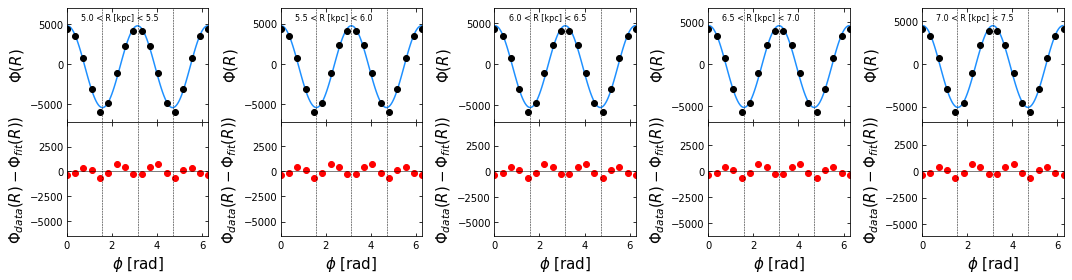

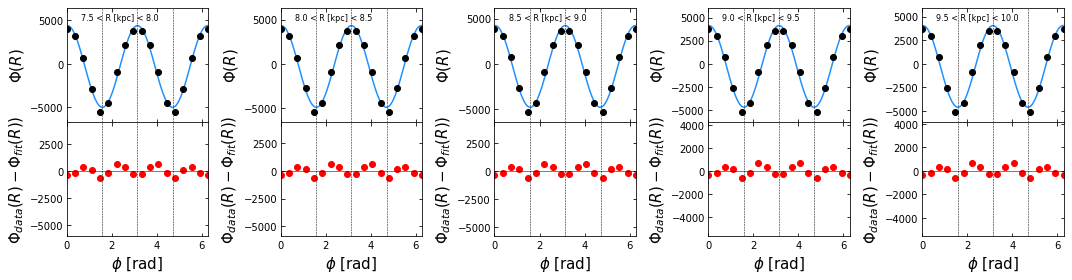

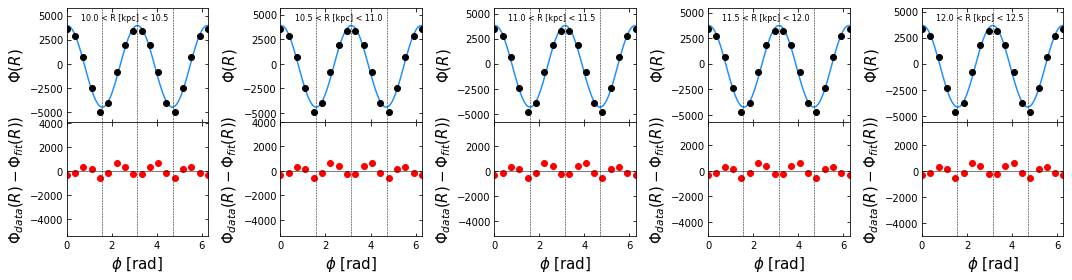

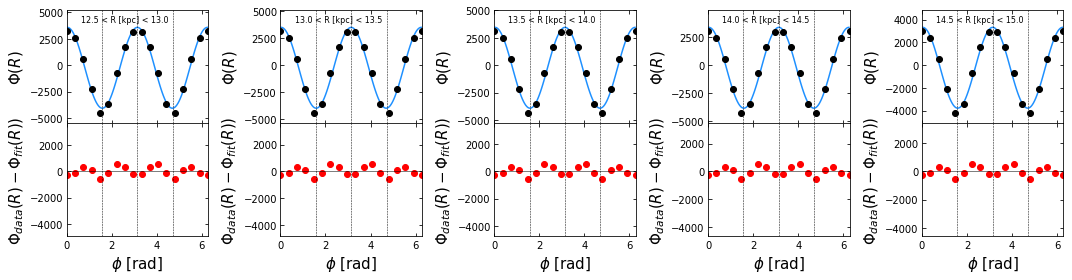

In [50]:
# dummy bin counter
bin_counter = 0

# Do this plotting in groups of 5. Assume that the number of bins will always be a multiple of 5
for i in range( int(n_bins/5) ):
    
    # Make the figure and the subplots
    fig = plt.figure( figsize=(15,4) )
    axs = fig.subplots(nrows=2,ncols=5)
    
    # Now for each radial bin average over azimuth, and do a power law fit.
    for j in range(5):
        
        # Define the array to hold the results from the azimuth sampling of the potentials
        pot_samp = np.zeros((n_az_samp,n_r_samp))
        
        # Loop over a number of azimuthal bins where data will be collected
        for k in range(n_az_samp):
            
            # Evaluate the potential at this azimuth
            # pdb.set_trace()
            pot_samp[k,:] = potential.evaluatePotentials(tripot, r_samp+r_bins[int(5*i+j)], 0., phi=az_samp[k]).value
        ###k
        
        # Now average all the azimuth samples and subtract this mean from each sample
        avg_pot = np.average(pot_samp, axis=0)
        pot_samp_off = pot_samp - avg_pot 
        
        # Now take the average and standard deviation of each azimuthal bin in the 
        # radial direction
        az_avg_pot = np.average(pot_samp_off, axis=1)
        az_std_pot = np.std(pot_samp_off, axis=1)
        
        # Now fit the averaged sample
        popt, pcov = curve_fit(sinusoid, az_samp, az_avg_pot, p0=[3000,2.,0.,-1000], ftol=0.01)
        
        # Now plot the averaged sample and the fitted curve
        axs[0,j].plot( np.arange(0,2*np.pi,0.05), sinusoid(np.arange(0,2*np.pi,0.05), *popt), 
                      color='DodgerBlue', linestyle='solid')
        axs[0,j].errorbar( az_samp, az_avg_pot, yerr=az_std_pot, fmt='o', color='Black', capsize=1.)
        
        # Decorate
        axs[0,j].axvline(np.pi/2, linestyle='dashed', color='black', linewidth=0.5)
        axs[0,j].axvline(np.pi, linestyle='dashed', color='black', linewidth=0.5)
        axs[0,j].axvline(3*np.pi/2, linestyle='dashed', color='black', linewidth=0.5)
        axs[0,j].annotate(str(r_bins[int(5*i+j)])+' < R [kpc] < '+str(r_bins[int(5*i+j)]+bin_size),
            (0.1,0.9), xycoords='axes fraction', fontsize=8)
        
        # Adjust
        axs[0,j].set_xlim(0, 2*np.pi)
        axs[0,j].set_ylim( np.amin(az_avg_pot)-0.25*popt[0], np.amax(az_avg_pot)+0.5*popt[0] )
        axs[0,j].set_ylabel(r'$\Phi(R)$', fontsize=15)
        axs[0,j].tick_params(right='on', top='on', direction='in', labelbottom='off')
        
        # Now plot the difference between the fit and the measurement
        axs[1,j].scatter( az_samp, az_avg_pot-sinusoid(az_samp, *popt), 
                      color='Red', linestyle='solid')
        
        # Decorate
        axs[1,j].axvline(np.pi/2, linestyle='dashed', color='black', linewidth=0.5)
        axs[1,j].axvline(np.pi, linestyle='dashed', color='black', linewidth=0.5)
        axs[1,j].axvline(3*np.pi/2, linestyle='dashed', color='black', linewidth=0.5)
        axs[1,j].axhline(0, color='Black', linewidth=0.5)
        
        # Adjust
        axs[1,j].set_xlim(0, 2*np.pi)
        axs[1,j].set_ylim( np.amin(az_avg_pot)-0.1*popt[0], np.amax(az_avg_pot)+0.1*popt[0] )
        axs[1,j].set_xlabel(r'$\phi$ [rad]', fontsize=15)
        axs[1,j].set_ylabel(r'$\Phi_{data}(R)-\Phi_{fit}(R))$', fontsize=15)
        axs[1,j].tick_params(right='on', top='on', direction='in')
    ###j
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    plt.show()
###i